# Import
Everything we need to import is here.

In [1]:
import os, fnmatch
import h5py
import pdb
import matplotlib.pyplot as plt
import time, pickle, pandas
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
import bsds_seg_gen as bs_utils
from color_smoothing import l0_smooth
from pylab import rcParams
from tqdm import tqdm
%matplotlib inline

/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


NOTE: The images for convertion must be in a folder called HEDSH. You can obviously change this name if you change the name below.

In [6]:
# dimensions of our patches.
img_width, img_height = 23, 23
#This is the root folder where all the images are kept, i.e. all the color cow*.jpg, monkey*.jpg and giraffe*.jpg
imagepath = "./HEDSH/"
#This just extracts the files. 
testimages = fnmatch.filter(os.listdir(imagepath),"*.jpg")
#Padding constants
im_pad,im_half_pad = 23,11
#Reduntant now
nameDict={0:"zer",1:"one"}
#fileset = trainimages, testimages, valimages
imageset=testimages
#This is for resizing - we want to generate edges faster
maxsize = (300, 300)

NOTE: The model MUST be in a folder called "final_models" - see below. The best model is "smoothed_dense_v2_2.hdf5"

In [17]:
model = Sequential()
#for smooth_dense, and non_smooth_sparse, r1_best model
model.add(Conv2D(32, 5,5,input_shape=(img_width, img_height, 3), subsample=(3,3)))
#for sparse mix
#model.add(Conv2D(64, 5,5,input_shape=(img_width, img_height, 3), subsample=(3,3)))
model.add(Activation("relu"))
#-------------------------------------------------------------
#for smooth_dense, r2_best, and non_smooth_sparse, r1_best
model.add(Conv2D(256, 3,3,  subsample=(2,2)))
#for sparse mix
#model.add(Conv2D(64, 3,3,  subsample=(2,2)))
model.add(Activation("relu"))
#-------------------------------------------------------------
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
#-------------------------------------------------------------

model.compile(loss = 'mean_squared_error',
              optimizer = 'rmsprop',
              metrics=['accuracy'])

#This first one is the optimal one. The others were previous, shittier models. You can try them if you want to get the older results.
# Ntte that r2_best doesn't work, so ignore that. To use any of these, uncomment the correct load weights here. 
#Then go to line 2 of this cell and uncomment the correct "model.add(conv2D). Do the same on line 8
model.load_weights("final_models/smoothed_dense_v2_2.hdf5")
#model.load_weights("final_models/non_smooth_sparse_v3.hdf5")
#model.load_weights("final_models/r1_best_model.hdf5")
#model.load_weights("final_models/r2_best_model.hdf5")
#model.load_weights("final_models/sparse_mix_v4.73.hdf5")
for layer in model.layers:
    layer.trainable = False
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])
print(model.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_7 (Convolution2D)  (None, 7, 7, 32)      2432        convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
activation_7 (Activation)        (None, 7, 7, 32)      0           convolution2d_7[0][0]            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 3, 3, 256)     73984       activation_7[0][0]               
____________________________________________________________________________________________________
activation_8 (Activation)        (None, 3, 3, 256)     0           convolution2d_8[0][0]            
___________________________________________________________________________________________

Choose which image to use.

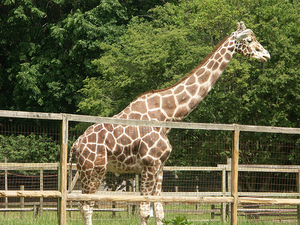

In [14]:
idx=89
assert idx < len(imageset)
# Open the image
tstIm = Image.open(imagepath+imageset[idx])
# Resize the image to help training go faster
tstIm.thumbnail(maxsize, Image.ANTIALIAS)
#im = l0_smooth(np.asarray(tstIm), 2, 3e-2)
tstIm

In [10]:
#res = bs_utils.seg_generator(truthpath+workset+truthset[idx], False)
#im = l0_smooth(np.asarray(Image.open(imagepath+workset+imageset[idx])))
#im = l0_smooth(np.asarray(Image.open(imagepath+imageset[idx])))
#im2 = np.asarray(Image.open(imagepath+imageset[idx]))
#im2=np.pad(im,((im_half_pad,im_half_pad),(im_half_pad,im_half_pad),(0,0)),"edge")

The following cell is the main piece. Detailed comments follow:

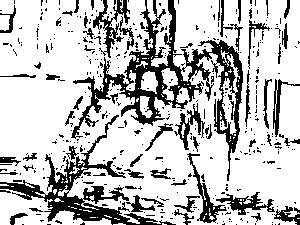

In [11]:
#Open the Image and reduce size for faster generation
tstIm = Image.open(imagepath+imageset[idx])
tstIm.thumbnail(maxsize, Image.ANTIALIAS)
#Smoothing - unnecessary, but if you want to do it, uncomment this line and comment and next
#im = l0_smooth(np.asarray(tstIm), 2, 3e-2)
im = np.asarray(tstIm)
#Pad the outside - necessary to get the edges right.
im2=np.pad(im,((im_half_pad,im_half_pad),(im_half_pad,im_half_pad),(0,0)),"edge")

#Set up the indices to work from (remember, we padded it, so we gotta start from what used to be [0,0])
i,j=im_half_pad,im_half_pad
tm = time.time()
#Initialize the output matrix
edge_result=np.zeros((im.shape[0],im.shape[1]))
#pdb.set_trace()
while i < im2.shape[0]-im_half_pad:
    while j < im2.shape[1]-im_half_pad:
        #Generate the patch
        im_patch = np.expand_dims(im2[i-im_half_pad:i+im_half_pad+1,j-im_half_pad:j+im_half_pad+1,:],axis=0)
        #pass it through the network
        edge_result[i-im_half_pad,j-im_half_pad] = model.predict(im_patch,1)[0,0].astype("uint8")
        j += 1
    i += 1
    j = im_half_pad
#Display the Image
Image.fromarray((1-edge_result.astype("uint8"))*255)
#Image.fromarray((1-edge_result.astype("uint8"))*255).save("NAME_GOES_HERE.jpg")

# Here be production code
The rest is to generate and store stuff. I haven't really fixed anything here to work on generic systems, so it might not work on your machine. If you want to, have fun.

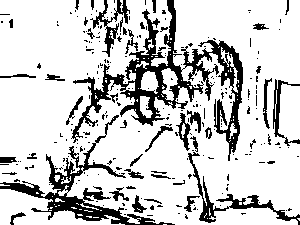

In [13]:
tstIm = Image.open(imagepath+imageset[idx])
tstIm.thumbnail(maxsize, Image.ANTIALIAS)
im = l0_smooth(np.asarray(tstIm), 2, 3e-2)
im2=np.pad(im,((im_half_pad,im_half_pad),(im_half_pad,im_half_pad),(0,0)),"edge")
Image.fromarray(im2)

i,j=im_half_pad,im_half_pad
tm = time.time()
edge_result=np.zeros((im.shape[0],im.shape[1]))
#pdb.set_trace()
while i < im2.shape[0]-im_half_pad:
    while j < im2.shape[1]-im_half_pad:
        #pdb.set_trace()
        im_patch = np.expand_dims(im2[i-im_half_pad:i+im_half_pad+1,j-im_half_pad:j+im_half_pad+1,:],axis=0)
        #pdb.set_trace()
        edge_result[i-im_half_pad,j-im_half_pad] = model.predict(im_patch,1)[0,0].astype("uint8")
        #pdb.set_trace()
        j += 1
    i += 1
    j = im_half_pad
Image.fromarray((1-edge_result.astype("uint8"))*255)

In [ ]:
#pdb.set_trace()
for idx in tqdm(range(len(imageset))):
    tstIm = Image.open(imagepath+imageset[idx])
    tstIm.thumbnail(maxsize, Image.ANTIALIAS)
    im = l0_smooth(np.asarray(tstIm), 2, 3e-2)
    im2=np.pad(im,((im_half_pad,im_half_pad),(im_half_pad,im_half_pad),(0,0)),"edge")
    Image.fromarray(im2)

    i,j=im_half_pad,im_half_pad
    tm = time.time()
    edge_result=np.zeros((im.shape[0],im.shape[1]))
    #pdb.set_trace()
    while i < im2.shape[0]-im_half_pad:
        while j < im2.shape[1]-im_half_pad:
            #pdb.set_trace()
            im_patch = np.expand_dims(im2[i-im_half_pad:i+im_half_pad+1,j-im_half_pad:j+im_half_pad+1,:],axis=0)
            #pdb.set_trace()
            edge_result[i-im_half_pad,j-im_half_pad] = model.predict(im_patch,1)[0,0].astype("uint8")
            #pdb.set_trace()
            j += 1
        i += 1
        j = im_half_pad
    Image.fromarray((1-edge_result.astype("uint8"))*255).save("augment/"+imageset[idx])
#print (time.time()-tm)